In [145]:
# append parent to path to allow imports
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [146]:
from pathlib import Path
import cv2
import numpy as np

from src.face import FaceDetector
from src.mask import MaskHandler
from src.utils.project_utils import Utils
from src.region import Region
from src.superpixels import SuperpixelExtractor
from src.feature import FeatureExtractor, EFeature

In [147]:
fd = FaceDetector("../assets/lbfmodel.yaml")
mh = MaskHandler()

IMAGE_PATH = Path("test_images/hover.png")

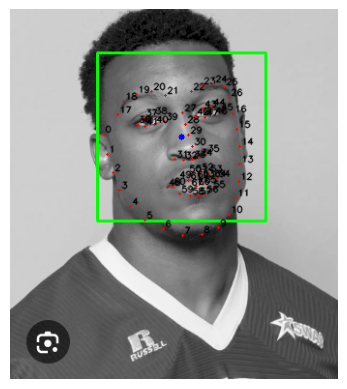

In [148]:
img_rgb, _, _, landmarks_all_faces = fd.detect(IMAGE_PATH, display_indices=True)
Utils.display(img_rgb)

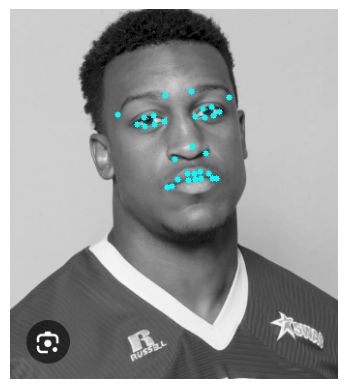

1


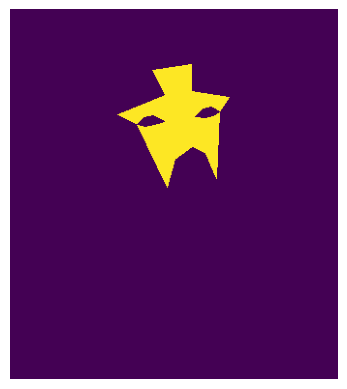

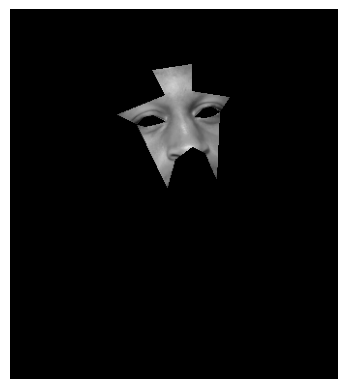

In [149]:
masked_img, selected_pts = mh.get_mask_points(IMAGE_PATH, landmarks_all_faces)
Utils.display(masked_img)

masks, masked_imgs = mh.build_masks(IMAGE_PATH, selected_pts, landmarks_all_faces)
print(len(masks))
Utils.display(masks[0])
Utils.display(masked_imgs[0])

1


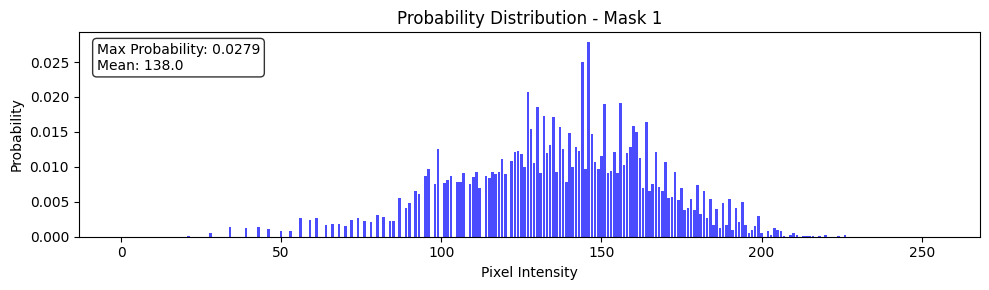

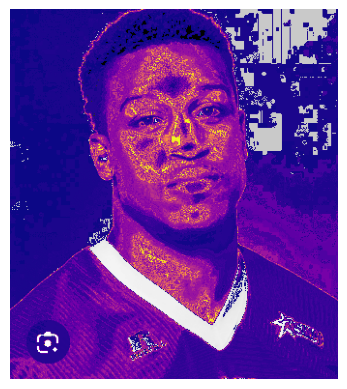

In [150]:
intensity_histograms = mh.get_intensity_histograms(IMAGE_PATH, masks)

print(len(intensity_histograms))
Utils.visualize_histograms(intensity_histograms)
Utils.apply_intensity_probability_map(IMAGE_PATH, intensity_histograms[0])

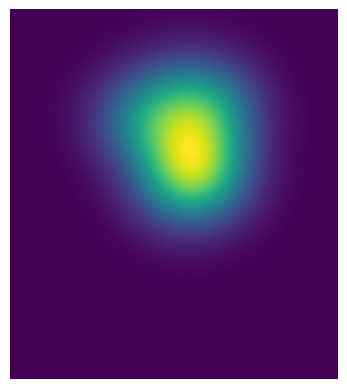

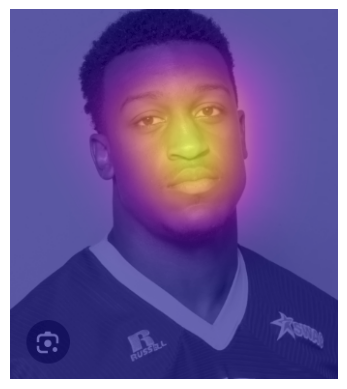

In [151]:
prior_face_masks, heatmaps, heatmaps_blended = mh.get_prior_face_masks(
    IMAGE_PATH, selected_pts
)

idx = 0
Utils.display(prior_face_masks[idx])
Utils.display(heatmaps_blended[idx])

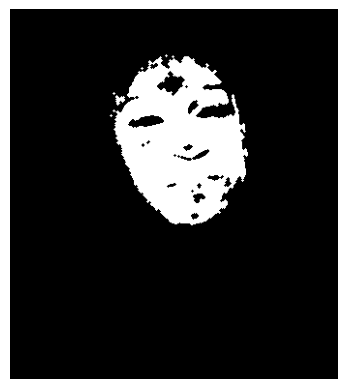

255 0


In [152]:
alpha = 0.9
lambda_ = 0.003
skin_pixel_maps = mh.get_skin_pixel_maps(
    IMAGE_PATH,
    intensity_histograms,
    prior_face_masks,
    alpha,
    lambda_,
    selected_pts,
    True,
)

skin_pixel_maps = [Utils.morphological_cleanup(s) for s in skin_pixel_maps]

idx = 0
Utils.display(skin_pixel_maps[idx], cmap="gray")
print(skin_pixel_maps[idx].max(), skin_pixel_maps[idx].min())

In [153]:
spe = SuperpixelExtractor()
slic, contoured_img, labels, num_superpixels = spe.get_slic_superpixels(IMAGE_PATH)

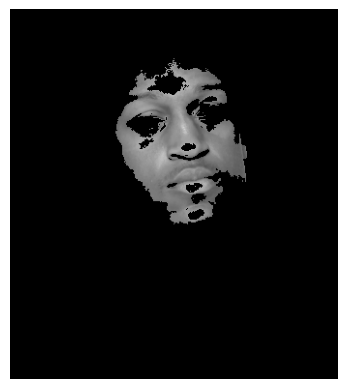

In [154]:
mask_labels = spe.get_mask_labels(slic, skin_pixel_maps[0], 0.9)
Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), mask_labels)

In [155]:
# Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), [500])
# neighbours = spe.get_neighbouring_superpixel_labels(slic, 500)
# Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), neighbours + [500])


In [156]:
fe = FeatureExtractor()
feature_vectors = fe.extract_all_features_superpixels(IMAGE_PATH, slic)

In [157]:
mask_fv, non_mask_fv = FeatureExtractor.separate_feature_vectors(feature_vectors, mask_labels)
print(len(mask_fv), len(non_mask_fv))

114 1178


In [158]:
FEATURE_SELECTION = [
    EFeature.MEAN_INTENSITY,
    EFeature.STD_INTENSITY,
    EFeature.ENTROPY,
    EFeature.LACUNARITY_VECTOR
]

most_favorable_divergences = [nfv.get_most_favorable_divergence(mask_fv, FEATURE_SELECTION) for nfv in non_mask_fv]

In [159]:
# most_favorable_divergences

In [160]:
# origin = 511

# neighbours = spe.get_neighbouring_superpixel_labels(slic, origin)
# print(neighbours)
# Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), [origin])
# Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), neighbours + [origin])


[118, 188, 219, 691, 794, 827, 867, 897, 963, 1068, 1075, 1139]


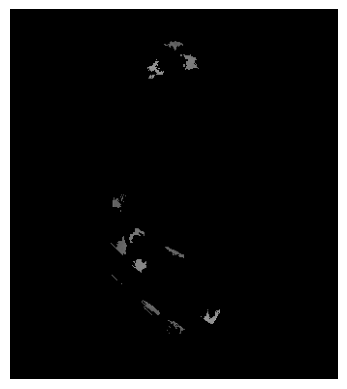

In [161]:
region = Region()

seed_superpixel_labels = region.select_seed_superpixels(
    most_favorable_divergences,
    FEATURE_SELECTION,
    0.99
)
print(seed_superpixel_labels)
Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), seed_superpixel_labels)

Starting Iterations of Region Growing Algorithm
----- Iteration 1/10 -----
Added 51 superpixels: [902, 521, 657, 1173, 792, 153, 793, 795, 152, 418, 1073, 1074, 695, 184, 185, 186, 187, 828, 189, 830, 831, 590, 217, 220, 862, 863, 624, 625, 120, 250]
Rejected 245  superpixels: [1032, 1033, 1034, 1035, 526, 528, 1040, 533, 534, 1067, 1069, 1071, 1076, 568, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 598, 600, 602, 1138, 627, 1140, 1141, 630, 119, 117, 634, 635, 636, 658, 660, 665, 154, 667, 668, 690, 692, 701, 190, 725, 218, 730, 732, 734, 225, 758, 760, 761, 253, 254, 255, 766, 765, 259, 260, 288, 826, 317, 318, 832, 325, 326, 328, 329, 861, 350, 351, 868, 358, 360, 361, 362, 363, 893, 894, 895, 896, 384, 386, 387, 388, 389, 901, 898, 393, 395, 929, 930, 931, 932, 421, 422, 423, 428, 431, 962, 964, 965, 456, 457, 465, 997, 486, 998, 1000, 494, 496, 501]


----- Iteration 2/10 -----
Added 16 superpixels: [864, 866, 903, 520, 1039, 659, 693, 183, 216, 829]
Rejected 51  superpixels: [

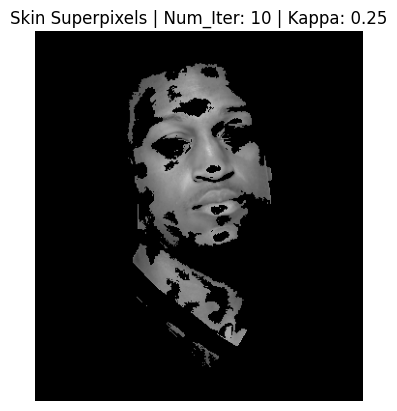

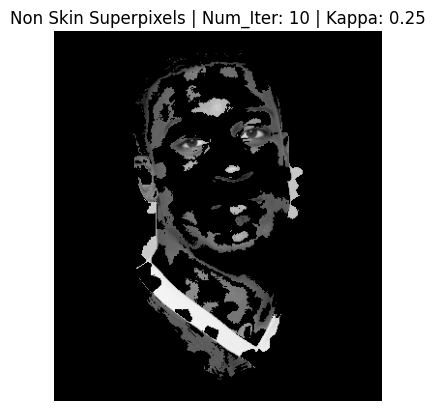

In [165]:
num_iterations = 10
kappa = 0.25

skin_superpixel_labels, non_skin_superpixel_labels = region.grow(
    slic,
    seed_superpixel_labels,
    feature_vectors,
    most_favorable_divergences,
    mask_labels,
    FEATURE_SELECTION,
    num_iterations,
    kappa,
)

Utils.display_selected_superpixels(
    IMAGE_PATH,
    slic.getLabels(),
    skin_superpixel_labels,
    title=f"Skin Superpixels | Num_Iter: {num_iterations} | Kappa: {kappa}"
)

Utils.display_selected_superpixels(
    IMAGE_PATH,
    slic.getLabels(),
    non_skin_superpixel_labels,
    title=f"Non Skin Superpixels | Num_Iter: {num_iterations} | Kappa: {kappa}"
)